# 🌊 Interactive Multiphase Pipeline & S-Riser Simulation

**Understanding Gas-Oil-Water Flow Dynamics using the OLGA Two-Fluid Model**

This notebook demonstrates multiphase flow in a long subsea pipeline connected to an S-riser using NeqSim's `TwoFluidPipe` model, which implements the industry-standard OLGA two-fluid equations.

## 📚 What You'll Learn

1. **Steady-State Analysis**: Initial pressure, temperature, and holdup profiles
2. **Dynamic Simulation**: Transient response to valve position changes
3. **Slugging Phenomena**: Terrain-induced and riser-base slugging
4. **Interactive Control**: Use sliders to control the outlet valve opening

## 🔬 The Two-Fluid Model

The OLGA two-fluid model solves separate conservation equations for each phase:

- **Gas Mass**: $\frac{\partial}{\partial t}(\alpha_g \rho_g A) + \frac{\partial}{\partial x}(\alpha_g \rho_g v_g A) = \Gamma_g$
- **Liquid Mass**: $\frac{\partial}{\partial t}(\alpha_L \rho_L A) + \frac{\partial}{\partial x}(\alpha_L \rho_L v_L A) = \Gamma_L$
- **Separate Momentum**: For gas and liquid phases with interfacial friction

---

## 1️⃣ Setup and Imports

In [2]:
# Import NeqSim - Direct Java Access via jneqsim gateway
from neqsim import jneqsim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle, FancyBboxPatch
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox
import time
import uuid

# Java classes
SystemSrkCPAstatoil = jneqsim.thermo.system.SystemSrkCPAstatoil
Stream = jneqsim.process.equipment.stream.Stream
TwoFluidPipe = jneqsim.process.equipment.pipeline.TwoFluidPipe
ThrottlingValve = jneqsim.process.equipment.valve.ThrottlingValve
ProcessSystem = jneqsim.process.processmodel.ProcessSystem

# Use Python's uuid for run IDs
import jpype
JavaUUID = jpype.JClass('java.util.UUID')

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 11

print("✅ NeqSim loaded successfully!")
print("📦 Using OLGA Two-Fluid Model for multiphase flow simulation")

✅ NeqSim loaded successfully!
📦 Using OLGA Two-Fluid Model for multiphase flow simulation


## 2️⃣ Define System Configuration

### Pipeline & S-Riser Geometry

```
                                    ┌─────────────────┐
                                    │    Topside      │
                                    │   Separator     │
                                    └────────┬────────┘
                                             │ ← Valve
                         S-Riser            ╱
                                          ╱
                                        ╱  (250m vertical)
                                      ╱
                                    ╱
    ═══════════════════════════════╗  
         Long Subsea Pipeline       ╚═══
              (40 km)                  ↖ Riser base
    ───────────────────────────────────────
          Seabed (-250m depth)
```

In [3]:
# ============ SYSTEM CONFIGURATION ============

# Pipeline parameters
PIPELINE_LENGTH = 40000.0    # 40 km horizontal pipeline
RISER_HEIGHT = 250.0         # 250 m S-riser
PIPE_DIAMETER = 0.3048       # 12-inch (304.8 mm) ID
ROUGHNESS = 4.5e-5           # Steel pipe roughness (m)

# Number of sections (pipeline + riser)
N_PIPELINE_SECTIONS = 80     # 500m per section
N_RISER_SECTIONS = 20        # ~12.5m per section (finer resolution for riser)
N_TOTAL_SECTIONS = N_PIPELINE_SECTIONS + N_RISER_SECTIONS

# Operating conditions
INLET_TEMPERATURE = 65.0     # °C (wellhead temperature)
INLET_PRESSURE = 100.0       # bara (wellhead pressure)
OUTLET_PRESSURE = 20.0       # bara (topside separator)
SEABED_TEMPERATURE = 4.0     # °C
MASS_FLOW_RATE = 30.0        # kg/s (base case)

# Heat transfer
HEAT_TRANSFER_COEFF = 15.0   # W/(m²·K) - insulated subsea pipe

print("📐 System Configuration:")
print(f"   Pipeline: {PIPELINE_LENGTH/1000:.0f} km × {PIPE_DIAMETER*1000:.0f} mm ID")
print(f"   S-Riser:  {RISER_HEIGHT:.0f} m vertical")
print(f"   Total sections: {N_TOTAL_SECTIONS} ({N_PIPELINE_SECTIONS} pipeline + {N_RISER_SECTIONS} riser)")
print(f"   Inlet: {INLET_PRESSURE} bara, {INLET_TEMPERATURE}°C")
print(f"   Outlet: {OUTLET_PRESSURE} bara (topside)")

📐 System Configuration:
   Pipeline: 40 km × 305 mm ID
   S-Riser:  250 m vertical
   Total sections: 100 (80 pipeline + 20 riser)
   Inlet: 100.0 bara, 65.0°C
   Outlet: 20.0 bara (topside)


## 3️⃣ Create Pipeline Profile with S-Riser

The elevation profile includes:
- Undulating seabed terrain (promotes liquid accumulation in valleys)
- S-shaped riser geometry (potential for severe slugging)

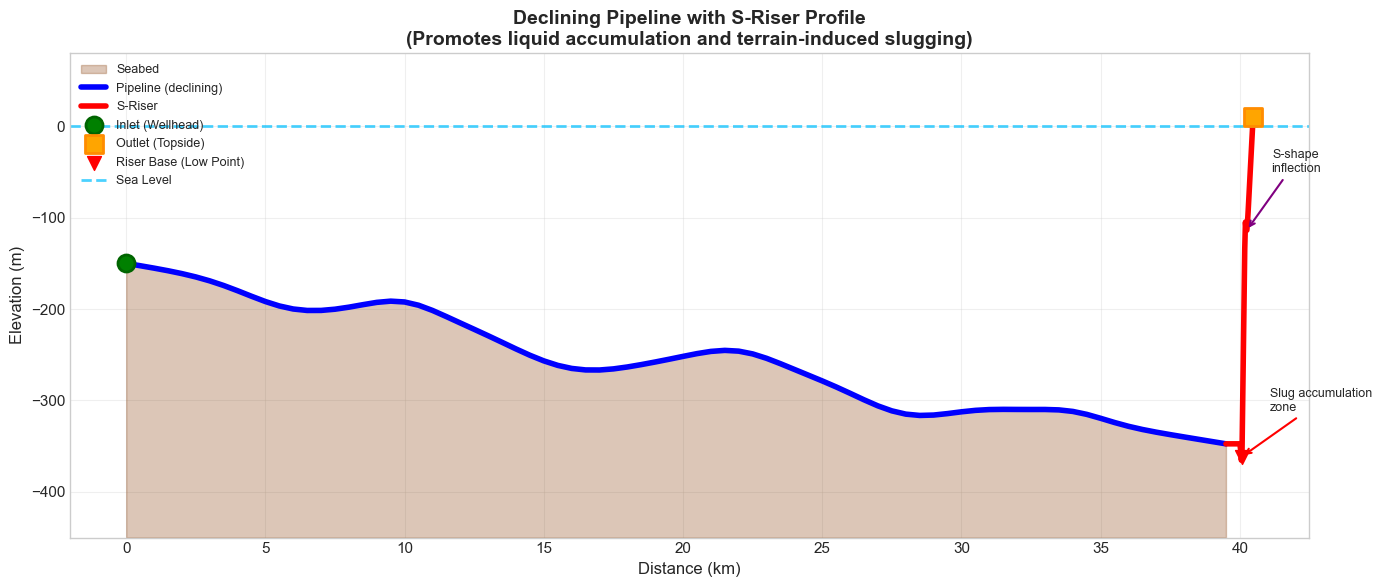


📍 Key elevations:
   Inlet (wellhead):    -150.0 m
   Riser base (low):    -365.4 m
   S-inflection:        -113.7 m
   Outlet (topside):    10.0 m

📐 Pipeline slope: -4.94 m/km (declining)


In [4]:
def create_pipeline_riser_profile(n_pipeline, n_riser, pipeline_length, riser_height):
    """
    Create elevation profile for pipeline + S-riser system.
    
    Pipeline: Slopes DOWNWARD from wellhead toward riser base (promotes liquid accumulation)
    S-Riser: True S-shape with:
        - Initial downward dip (riser base low point - severe slug zone)
        - Upward vertical section
        - Horizontal/slight dip mid-section (the "S" inflection)
        - Final vertical rise to topside
    
    Returns:
        positions: distance along flowline (m)
        elevations: elevation at each point (m)
    """
    n_total = n_pipeline + n_riser
    total_length = pipeline_length + riser_height * 2.0  # S-riser path length ~ 2x height
    
    positions = np.zeros(n_total)
    elevations = np.zeros(n_total)
    
    # Pipeline section - DECLINING from wellhead to riser base
    dx_pipeline = pipeline_length / n_pipeline
    
    # Wellhead at -150m, declining to riser base at -350m (deeper seabed)
    wellhead_depth = -150.0      # Shallower at inlet
    riser_base_depth = -350.0    # Deeper at riser base
    total_drop = riser_base_depth - wellhead_depth  # -200m drop
    
    for i in range(n_pipeline):
        x = i * dx_pipeline
        positions[i] = x
        x_norm = x / pipeline_length
        
        # Linear decline with undulations superimposed
        base_elevation = wellhead_depth + total_drop * x_norm
        
        # Undulations (valleys trap liquid, hills release slugs)
        undulation = 0.0
        undulation += -20.0 * np.exp(-((x_norm - 0.15) / 0.06)**2)  # Valley 1
        undulation += +10.0 * np.exp(-((x_norm - 0.25) / 0.04)**2)  # Hill 1
        undulation += -35.0 * np.exp(-((x_norm - 0.40) / 0.08)**2)  # Valley 2 (deep)
        undulation += +15.0 * np.exp(-((x_norm - 0.55) / 0.05)**2)  # Hill 2
        undulation += -25.0 * np.exp(-((x_norm - 0.70) / 0.06)**2)  # Valley 3
        undulation += +8.0 * np.exp(-((x_norm - 0.85) / 0.04)**2)   # Small hill before riser
        
        elevations[i] = base_elevation + undulation
    
    # S-Riser section - TRUE S-SHAPE
    # The S-riser has these segments:
    # 1. Initial dip below pipeline end (riser base low point) - 0 to 15%
    # 2. First vertical rise section - 15% to 40%
    # 3. Horizontal/slight dip (S inflection) - 40% to 60%
    # 4. Second vertical rise to topside - 60% to 100%
    
    riser_path_length = riser_height * 2.0
    dx_riser = riser_path_length / n_riser
    
    # Key elevations for S-shape
    pipeline_end_elev = elevations[n_pipeline - 1]
    low_point_elev = riser_base_depth - 20.0  # 20m below pipeline end (slug accumulation)
    mid_platform_elev = -100.0   # Mid-riser horizontal section
    topside_elev = 10.0          # Above sea level
    
    for j in range(n_riser):
        i = n_pipeline + j
        s = j / (n_riser - 1) if n_riser > 1 else 0  # Normalized position (0 to 1)
        positions[i] = pipeline_length + j * dx_riser
        
        if s <= 0.15:
            # Segment 1: Dip down to riser base low point
            t = s / 0.15
            # Smooth transition using cosine
            elevations[i] = pipeline_end_elev + (low_point_elev - pipeline_end_elev) * (0.5 - 0.5 * np.cos(t * np.pi))
            
        elif s <= 0.40:
            # Segment 2: First vertical rise (steep)
            t = (s - 0.15) / 0.25
            elevations[i] = low_point_elev + (mid_platform_elev - low_point_elev) * t
            
        elif s <= 0.60:
            # Segment 3: Horizontal/slight dip - the "S" inflection
            t = (s - 0.40) / 0.20
            # Slight dip in the middle creates the S-shape
            dip_amplitude = 15.0
            elevations[i] = mid_platform_elev - dip_amplitude * np.sin(t * np.pi)
            
        else:
            # Segment 4: Final rise to topside
            t = (s - 0.60) / 0.40
            start_elev = mid_platform_elev - 0  # End of inflection (back to mid level)
            elevations[i] = start_elev + (topside_elev - start_elev) * t
    
    return positions, elevations

# Create the profile
positions, elevations = create_pipeline_riser_profile(
    N_PIPELINE_SECTIONS, N_RISER_SECTIONS, PIPELINE_LENGTH, RISER_HEIGHT
)

# Visualize the profile
fig, ax = plt.subplots(figsize=(14, 6))

# Plot seabed (fill below pipeline)
ax.fill_between(positions[:N_PIPELINE_SECTIONS]/1000, elevations[:N_PIPELINE_SECTIONS], 
                -450, alpha=0.3, color='saddlebrown', label='Seabed')

# Plot pipeline (declining toward riser)
ax.plot(positions[:N_PIPELINE_SECTIONS]/1000, elevations[:N_PIPELINE_SECTIONS], 
        'b-', linewidth=4, label='Pipeline (declining)')

# Plot S-Riser
ax.plot(positions[N_PIPELINE_SECTIONS-1:]/1000, elevations[N_PIPELINE_SECTIONS-1:], 
        'r-', linewidth=4, label='S-Riser')

# Mark key locations
ax.scatter([0], [elevations[0]], s=150, c='green', zorder=5, marker='o', 
           edgecolors='darkgreen', linewidths=2, label='Inlet (Wellhead)')
ax.scatter([positions[-1]/1000], [elevations[-1]], s=150, c='orange', zorder=5, marker='s',
           edgecolors='darkorange', linewidths=2, label='Outlet (Topside)')

# Mark riser base (slug accumulation zone)
riser_base_idx = N_PIPELINE_SECTIONS + int(0.15 * N_RISER_SECTIONS)
ax.scatter([positions[riser_base_idx]/1000], [elevations[riser_base_idx]], 
           s=100, c='red', zorder=5, marker='v', label='Riser Base (Low Point)')

# Sea level
ax.axhline(y=0, color='deepskyblue', linestyle='--', linewidth=2, alpha=0.7, label='Sea Level')

# Add annotations
ax.annotate('Slug accumulation\nzone', 
            xy=(positions[riser_base_idx]/1000, elevations[riser_base_idx]),
            xytext=(positions[riser_base_idx]/1000 + 1, elevations[riser_base_idx] + 50),
            fontsize=9, ha='left',
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

ax.annotate('S-shape\ninflection', 
            xy=(positions[N_PIPELINE_SECTIONS + int(0.5 * N_RISER_SECTIONS)]/1000, 
                elevations[N_PIPELINE_SECTIONS + int(0.5 * N_RISER_SECTIONS)]),
            xytext=(42, -50),
            fontsize=9, ha='center',
            arrowprops=dict(arrowstyle='->', color='purple', lw=1.5))

ax.set_xlabel('Distance (km)', fontsize=12)
ax.set_ylabel('Elevation (m)', fontsize=12)
ax.set_title('Declining Pipeline with S-Riser Profile\n(Promotes liquid accumulation and terrain-induced slugging)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-450, 80)

plt.tight_layout()
plt.show()

print(f"\n📍 Key elevations:")
print(f"   Inlet (wellhead):    {elevations[0]:.1f} m")
print(f"   Riser base (low):    {min(elevations[N_PIPELINE_SECTIONS:N_PIPELINE_SECTIONS+5]):.1f} m")
print(f"   S-inflection:        {elevations[N_PIPELINE_SECTIONS + int(0.5*N_RISER_SECTIONS)]:.1f} m")
print(f"   Outlet (topside):    {elevations[-1]:.1f} m")
print(f"\n📐 Pipeline slope: {(elevations[N_PIPELINE_SECTIONS-1] - elevations[0])/PIPELINE_LENGTH*1000:.2f} m/km (declining)")

## 4️⃣ Create Multiphase Fluid (Gas + Oil + Water)

Using CPA equation of state for accurate water modeling in hydrocarbon systems.

In [ ]:
def create_multiphase_fluid(temperature_C, pressure_bara):
    """
    Create a gas-oil-water fluid using CPA equation of state.
    
    Returns:
        SystemInterface: Configured fluid system
    """
    # CPA equation of state (best for water + hydrocarbons)
    fluid = SystemSrkCPAstatoil(temperature_C + 273.15, pressure_bara)
    
    # Gas-dominant composition with condensate
    fluid.addComponent("nitrogen", 1.5)      # mol%
    fluid.addComponent("CO2", 2.0)
    fluid.addComponent("methane", 70.0)
    fluid.addComponent("ethane", 8.0)
    fluid.addComponent("propane", 5.0)
    fluid.addComponent("i-butane", 2.0)
    fluid.addComponent("n-butane", 2.5)
    
    # Heavier components (oil/condensate)
    fluid.addComponent("i-pentane", 1.5)
    fluid.addComponent("n-pentane", 2.0)
    fluid.addComponent("n-hexane", 1.5)
    fluid.addComponent("n-heptane", 1.5)
    fluid.addComponent("n-octane", 1.0)
    
    # Water (for three-phase flow)
    fluid.addComponent("water", 1.5)         # ~1.5 mol% water
    
    # Set CPA mixing rule (rule 10 for water with hydrocarbons)
    fluid.setMixingRule(10)
    
    # Enable multi-phase check for three-phase flash
    fluid.setMultiPhaseCheck(True)
    
    return fluid

# Create and test the fluid
test_fluid = create_multiphase_fluid(INLET_TEMPERATURE, INLET_PRESSURE)

# Run TPflash to check phases
from neqsim import jneqsim
ThermodynamicOperations = jneqsim.thermodynamicoperations.ThermodynamicOperations
thermoOps = ThermodynamicOperations(test_fluid)
thermoOps.TPflash()
test_fluid.initProperties()

print("🧪 Fluid Composition and Phase Information:")
print(f"   Temperature: {INLET_TEMPERATURE}°C, Pressure: {INLET_PRESSURE} bara")
print(f"   Number of phases: {test_fluid.getNumberOfPhases()}")

for p in range(test_fluid.getNumberOfPhases()):
    phase = test_fluid.getPhase(p)
    print(f"   Phase {p+1}: {phase.getPhaseTypeName()}")
    print(f"      - Volume fraction: {phase.getVolume('m3') / test_fluid.getVolume('m3') * 100:.2f}%")
    print(f"      - Density: {phase.getDensity('kg/m3'):.1f} kg/m³")

🧪 Fluid Composition and Phase Information:
   Temperature: 65.0°C, Pressure: 100.0 bara
   Number of phases: 3
   Phase 1: gas
      - Volume fraction: 93.82%
      - Density: 0.0 kg/m³
   Phase 2: oil
      - Volume fraction: 6.07%
      - Density: 0.0 kg/m³
   Phase 3: aqueous
      - Volume fraction: 0.10%
      - Density: 0.0 kg/m³


## 5️⃣ Build the Process Model

Create the pipeline-riser system with the OLGA two-fluid model.

In [6]:
def create_pipeline_system(mass_flow_rate, valve_opening=1.0):
    """
    Create the complete pipeline-riser-valve system.
    
    Args:
        mass_flow_rate: Inlet mass flow rate (kg/s)
        valve_opening: Outlet valve opening (0-1)
        
    Returns:
        tuple: (pipe, valve, inlet_stream)
    """
    # Create fluid
    fluid = create_multiphase_fluid(INLET_TEMPERATURE, INLET_PRESSURE)
    
    # Create inlet stream
    inlet = Stream("Inlet", fluid)
    inlet.setFlowRate(float(mass_flow_rate), "kg/sec")
    inlet.setTemperature(float(INLET_TEMPERATURE), "C")
    inlet.setPressure(float(INLET_PRESSURE), "bara")
    inlet.run()
    
    # Create TwoFluidPipe with OLGA model
    total_length = PIPELINE_LENGTH + RISER_HEIGHT * 1.5
    pipe = TwoFluidPipe("Pipeline-Riser", inlet)
    pipe.setLength(total_length)
    pipe.setDiameter(PIPE_DIAMETER)
    pipe.setNumberOfSections(N_TOTAL_SECTIONS)
    pipe.setRoughness(ROUGHNESS)
    
    # Set elevation profile (converted to Java array)
    pipe.setElevationProfile(elevations.tolist())
    
    # Configure OLGA two-fluid model settings
    pipe.setOLGAModelType(TwoFluidPipe.OLGAModelType.FULL)
    pipe.setSlugTrackingMode(TwoFluidPipe.SlugTrackingMode.LAGRANGIAN)
    pipe.setEnableTerrainTracking(True)
    pipe.setEnableSevereSlugModel(True)
    
    # Heat transfer settings
    pipe.setHeatTransferCoefficient(float(HEAT_TRANSFER_COEFF))
    pipe.setSurfaceTemperature(float(SEABED_TEMPERATURE), "C")
    
    # Set outlet pressure (downstream of valve)
    pipe.setOutletPressure(float(OUTLET_PRESSURE), "bara")
    
    return pipe, inlet

print("🔧 Creating pipeline-riser system...")
pipe, inlet_stream = create_pipeline_system(MASS_FLOW_RATE)
print("✅ System created with OLGA Full model")
print(f"   - Lagrangian slug tracking: ENABLED")
print(f"   - Terrain tracking: ENABLED")
print(f"   - Severe slug model: ENABLED")

🔧 Creating pipeline-riser system...
✅ System created with OLGA Full model
   - Lagrangian slug tracking: ENABLED
   - Terrain tracking: ENABLED
   - Severe slug model: ENABLED


## 6️⃣ Run Steady-State Simulation

First, establish the steady-state operating point before running dynamics.

In [7]:
print("⏳ Running steady-state simulation...")
start_time = time.time()

# Run steady-state
pipe.run()

elapsed = time.time() - start_time
print(f"✅ Steady-state converged in {elapsed:.2f} seconds")

# Extract results
pressure_profile = np.array(pipe.getPressureProfile()) / 1e5  # Convert Pa to bar
temperature_profile = np.array(pipe.getTemperatureProfile()) - 273.15  # Convert K to °C
liquid_holdup = np.array(pipe.getLiquidHoldupProfile())
oil_holdup = np.array(pipe.getOilHoldupProfile())
water_holdup = np.array(pipe.getWaterHoldupProfile())
gas_velocity = np.array(pipe.getGasVelocityProfile())
liquid_velocity = np.array(pipe.getLiquidVelocityProfile())
flow_regimes = pipe.getFlowRegimeProfile()

# Get liquid inventory
liquid_inventory = pipe.getLiquidInventory("m3")

print(f"\n📊 Steady-State Results:")
print(f"   Inlet pressure:  {pressure_profile[0]:.1f} bara")
print(f"   Outlet pressure: {pressure_profile[-1]:.1f} bara")
print(f"   Pressure drop:   {pressure_profile[0] - pressure_profile[-1]:.1f} bar")
print(f"   Outlet temperature: {temperature_profile[-1]:.1f}°C")
print(f"   Total liquid inventory: {liquid_inventory:.1f} m³")
print(f"   Average liquid holdup: {np.mean(liquid_holdup)*100:.1f}%")

⏳ Running steady-state simulation...
✅ Steady-state converged in 357.97 seconds

📊 Steady-State Results:
   Inlet pressure:  100.0 bara
   Outlet pressure: 91.5 bara
   Pressure drop:   8.5 bar
   Outlet temperature: 4.1°C
   Total liquid inventory: 1270.8 m³
   Average liquid holdup: 93.7%


## 7️⃣ Visualize Steady-State Profiles

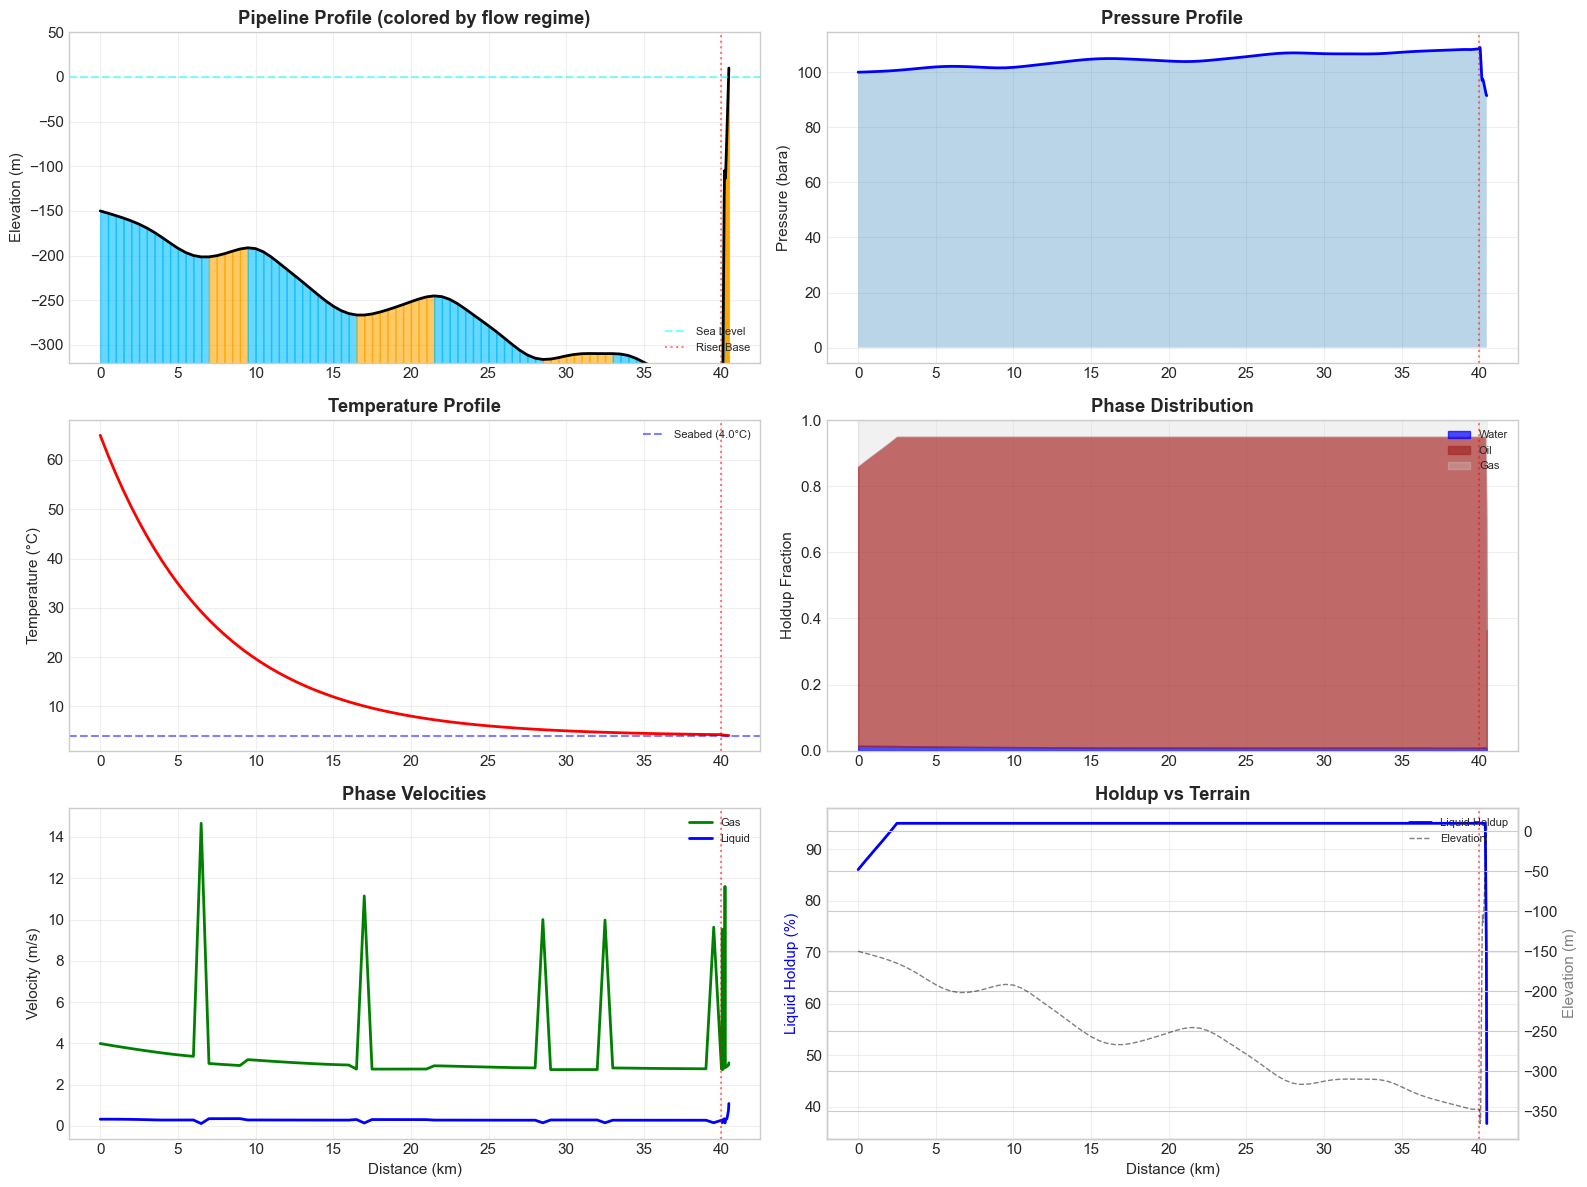

In [8]:
def plot_steady_state_profiles(positions, pressure, temperature, 
                                liquid_holdup, oil_holdup, water_holdup,
                                gas_vel, liq_vel, elevations, flow_regimes):
    """
    Create comprehensive visualization of steady-state profiles.
    """
    fig = plt.figure(figsize=(16, 12))
    
    # Convert positions to km
    pos_km = positions / 1000
    
    # 1. Elevation profile with flow regime coloring
    ax1 = fig.add_subplot(3, 2, 1)
    
    # Color-code by flow regime
    regime_colors = {
        'STRATIFIED_SMOOTH': 'lightblue',
        'STRATIFIED_WAVY': 'deepskyblue',
        'SLUG': 'orange',
        'ANNULAR': 'purple',
        'CHURN': 'red',
        'BUBBLE': 'green',
        'DISPERSED_BUBBLE': 'lime'
    }
    
    for i in range(len(positions)-1):
        regime_name = str(flow_regimes[i]) if i < len(flow_regimes) else 'STRATIFIED_SMOOTH'
        color = regime_colors.get(regime_name, 'gray')
        ax1.fill_between([pos_km[i], pos_km[i+1]], [elevations[i], elevations[i+1]], 
                        -350, alpha=0.6, color=color)
    
    ax1.plot(pos_km, elevations, 'k-', linewidth=2)
    ax1.axhline(y=0, color='cyan', linestyle='--', alpha=0.5, label='Sea Level')
    ax1.axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5, label='Riser Base')
    ax1.set_ylabel('Elevation (m)')
    ax1.set_title('Pipeline Profile (colored by flow regime)', fontweight='bold')
    ax1.legend(loc='lower right', fontsize=8)
    ax1.set_ylim(-320, 50)
    ax1.grid(True, alpha=0.3)
    
    # 2. Pressure profile
    ax2 = fig.add_subplot(3, 2, 2)
    ax2.plot(pos_km, pressure, 'b-', linewidth=2)
    ax2.fill_between(pos_km, pressure, alpha=0.3)
    ax2.axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5)
    ax2.set_ylabel('Pressure (bara)')
    ax2.set_title('Pressure Profile', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Temperature profile
    ax3 = fig.add_subplot(3, 2, 3)
    ax3.plot(pos_km, temperature, 'r-', linewidth=2)
    ax3.axhline(y=SEABED_TEMPERATURE, color='blue', linestyle='--', 
                alpha=0.5, label=f'Seabed ({SEABED_TEMPERATURE}°C)')
    ax3.axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5)
    ax3.set_ylabel('Temperature (°C)')
    ax3.set_title('Temperature Profile', fontweight='bold')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # 4. Holdup profiles (stacked)
    ax4 = fig.add_subplot(3, 2, 4)
    ax4.fill_between(pos_km, 0, water_holdup, alpha=0.7, color='blue', label='Water')
    ax4.fill_between(pos_km, water_holdup, water_holdup + oil_holdup, 
                     alpha=0.7, color='brown', label='Oil')
    ax4.fill_between(pos_km, water_holdup + oil_holdup, 1.0, 
                     alpha=0.3, color='lightgray', label='Gas')
    ax4.axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5)
    ax4.set_ylabel('Holdup Fraction')
    ax4.set_title('Phase Distribution', fontweight='bold')
    ax4.legend(loc='upper right', fontsize=8)
    ax4.set_ylim(0, 1)
    ax4.grid(True, alpha=0.3)
    
    # 5. Velocity profiles
    ax5 = fig.add_subplot(3, 2, 5)
    ax5.plot(pos_km, gas_vel, 'g-', linewidth=2, label='Gas')
    ax5.plot(pos_km, liq_vel, 'b-', linewidth=2, label='Liquid')
    ax5.axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5)
    ax5.set_xlabel('Distance (km)')
    ax5.set_ylabel('Velocity (m/s)')
    ax5.set_title('Phase Velocities', fontweight='bold')
    ax5.legend(loc='upper right', fontsize=8)
    ax5.grid(True, alpha=0.3)
    
    # 6. Liquid holdup with elevation overlay
    ax6 = fig.add_subplot(3, 2, 6)
    ax6_twin = ax6.twinx()
    
    l1, = ax6.plot(pos_km, liquid_holdup * 100, 'b-', linewidth=2, label='Liquid Holdup')
    l2, = ax6_twin.plot(pos_km, elevations, 'k--', linewidth=1, alpha=0.5, label='Elevation')
    
    ax6.axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5)
    ax6.set_xlabel('Distance (km)')
    ax6.set_ylabel('Liquid Holdup (%)', color='blue')
    ax6_twin.set_ylabel('Elevation (m)', color='gray')
    ax6.set_title('Holdup vs Terrain', fontweight='bold')
    ax6.legend([l1, l2], ['Liquid Holdup', 'Elevation'], loc='upper right', fontsize=8)
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot steady-state profiles
plot_steady_state_profiles(
    positions, pressure_profile, temperature_profile,
    liquid_holdup, oil_holdup, water_holdup,
    gas_velocity, liquid_velocity, elevations, flow_regimes
)

## 8️⃣ Pipeline Cross-Section Visualization

Visualize the flow pattern inside the pipe at different locations.

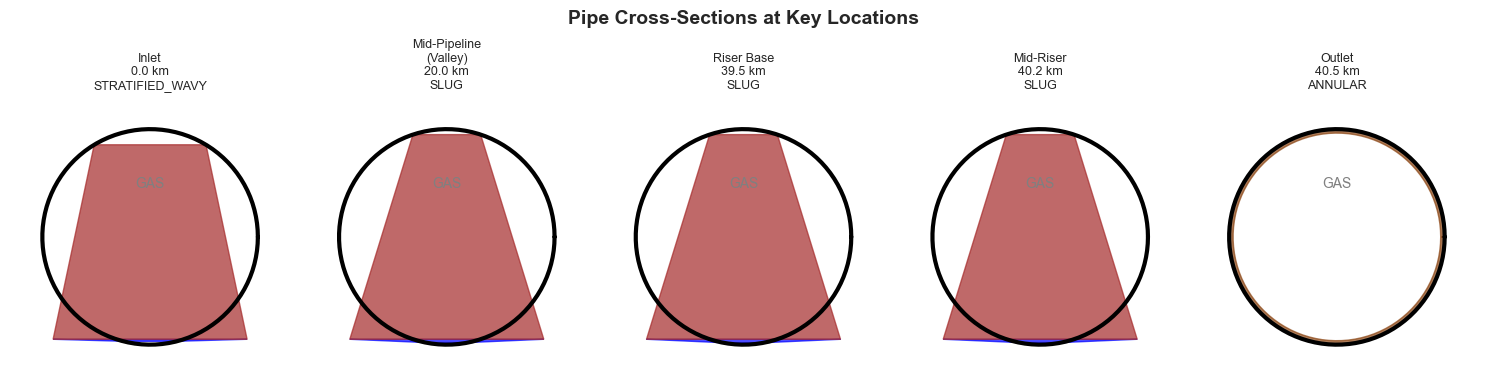

In [10]:
def draw_pipe_cross_section(ax, holdup_liq, holdup_water, holdup_oil, regime, title, pos_km):
    """
    Draw a cross-section of the pipe showing phase distribution.
    """
    ax.set_aspect('equal')
    
    # Pipe wall
    theta = np.linspace(0, 2*np.pi, 100)
    R = 1.0  # Normalized radius
    ax.plot(R * np.cos(theta), R * np.sin(theta), 'k-', linewidth=3)
    
    # Calculate liquid level (for stratified flow visualization)
    total_liq = holdup_liq
    
    # Different visualization based on flow regime
    regime_str = str(regime)
    
    if 'STRATIFIED' in regime_str or 'SLUG' in regime_str:
        # Stratified flow - liquid at bottom
        # Find liquid level height h such that cross-section area = holdup * pi*R^2
        # Using approximation: h ≈ 2R * holdup^0.5 for small holdup
        if total_liq > 0.01:
            h = 2 * R * np.sqrt(total_liq)  # Simplified height calculation
            h = min(h, 2*R)
            y_level = -R + h
            
            # Water layer (bottom)
            if holdup_water > 0.001:
                h_water = h * (holdup_water / total_liq) if total_liq > 0 else 0
                y_water = -R + h_water
                
                # Fill water (blue)
                theta_water = np.linspace(-np.pi/2, 3*np.pi/2, 100)
                for i, t in enumerate(theta_water):
                    if R * np.sin(t) < y_water:
                        pass  # Below water level
                
                # Simplified: draw as rectangle-ish shape at bottom
                water_poly_x = np.concatenate([[-np.sqrt(max(0, R**2 - y_water**2))], 
                                              np.linspace(-R*0.9, R*0.9, 20),
                                              [np.sqrt(max(0, R**2 - y_water**2))]])
                water_poly_y = np.concatenate([[y_water], 
                                              np.ones(20) * (-R + 0.05),
                                              [y_water]])
                ax.fill(water_poly_x, water_poly_y, color='blue', alpha=0.7, label='Water')
            
            # Oil layer (on top of water)
            if holdup_oil > 0.001:
                y_water = -R + h * (holdup_water / total_liq) if total_liq > 0 else -R
                oil_poly_x = np.concatenate([[-np.sqrt(max(0, R**2 - y_level**2))], 
                                           np.linspace(-0.9*R, 0.9*R, 20),
                                           [np.sqrt(max(0, R**2 - y_level**2))]])
                oil_poly_y = np.concatenate([[y_level], 
                                           np.ones(20) * max(-R+0.05, y_water),
                                           [y_level]])
                ax.fill(oil_poly_x, oil_poly_y, color='brown', alpha=0.7, label='Oil')
    
    elif 'ANNULAR' in regime_str:
        # Annular flow - liquid film on wall
        film_thickness = 0.1 * total_liq  # Thin film
        theta = np.linspace(0, 2*np.pi, 100)
        r_inner = R * (1 - film_thickness)
        
        # Draw film (mixture of oil and water)
        ax.fill_between(R * np.cos(theta), R * np.sin(theta), alpha=0)
        ax.fill(np.append(R * np.cos(theta), r_inner * np.cos(theta[::-1])),
               np.append(R * np.sin(theta), r_inner * np.sin(theta[::-1])),
               color='saddlebrown', alpha=0.7, label='Liquid Film')
    
    else:
        # Default: dispersed or bubble - show as droplets
        np.random.seed(42)
        n_drops = int(20 * total_liq)
        for _ in range(n_drops):
            x = np.random.uniform(-0.8*R, 0.8*R)
            y = np.random.uniform(-0.8*R, 0.8*R)
            if x**2 + y**2 < (0.85*R)**2:
                color = 'blue' if np.random.random() < holdup_water/max(total_liq, 0.01) else 'brown'
                ax.add_patch(Circle((x, y), 0.05, color=color, alpha=0.6))
    
    # Gas phase label
    ax.text(0, 0.5, 'GAS', ha='center', va='center', fontsize=10, color='gray')
    
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_title(f'{title}\n{pos_km:.1f} km\n{regime_str}', fontsize=9)
    ax.axis('off')

# Draw cross-sections at key locations
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

# Select key locations
locations = [
    (0, 'Inlet'),
    (int(N_PIPELINE_SECTIONS * 0.5), 'Mid-Pipeline\n(Valley)'),
    (N_PIPELINE_SECTIONS - 1, 'Riser Base'),
    (N_PIPELINE_SECTIONS + N_RISER_SECTIONS // 2, 'Mid-Riser'),
    (N_TOTAL_SECTIONS - 1, 'Outlet')
]

for ax, (idx, title) in zip(axes, locations):
    draw_pipe_cross_section(
        ax, 
        liquid_holdup[idx], 
        water_holdup[idx], 
        oil_holdup[idx],
        flow_regimes[idx],
        title,
        positions[idx] / 1000
    )

fig.suptitle('Pipe Cross-Sections at Key Locations', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9️⃣ Interactive Dynamic Simulation

Use sliders to control the outlet valve and observe the dynamic response of the system.

In [12]:
# Store simulation state
class SimulationState:
    def __init__(self):
        self.pipe = None
        self.inlet = None
        self.sim_time = 0.0
        self.history = {
            'time': [],
            'inlet_pressure': [],
            'outlet_pressure': [],
            'liquid_inventory': [],
            'outlet_holdup': [],
            'valve_opening': []
        }
        self.run_id = None
        
    def initialize(self, mass_flow):
        """Initialize or reinitialize the simulation."""
        self.pipe, self.inlet = create_pipeline_system(mass_flow)
        self.pipe.run()  # Steady state
        self.sim_time = 0.0
        self.run_id = JavaUUID.randomUUID()
        self.history = {k: [] for k in self.history}
        self._record_state(1.0)
        
    def _record_state(self, valve_opening):
        """Record current state to history."""
        p_profile = np.array(self.pipe.getPressureProfile()) / 1e5
        liq_holdup = np.array(self.pipe.getLiquidHoldupProfile())
        
        self.history['time'].append(self.sim_time)
        self.history['inlet_pressure'].append(p_profile[0])
        self.history['outlet_pressure'].append(p_profile[-1])
        self.history['liquid_inventory'].append(self.pipe.getLiquidInventory("m3"))
        self.history['outlet_holdup'].append(liq_holdup[-1])
        self.history['valve_opening'].append(valve_opening)
        
    def step(self, dt, valve_opening, flow_rate):
        """Advance simulation by dt seconds."""
        # Update inlet conditions
        self.inlet.setFlowRate(float(flow_rate), "kg/sec")
        self.inlet.run()
        
        # Adjust outlet pressure based on valve opening
        # Lower valve opening = higher back pressure
        effective_outlet_P = OUTLET_PRESSURE + (1.0 - valve_opening) * 30.0  # Up to 30 bar increase
        self.pipe.setOutletPressure(float(effective_outlet_P), "bara")
        
        # Run transient step
        self.pipe.runTransient(float(dt), self.run_id)
        self.sim_time += dt
        self._record_state(valve_opening)

# Initialize simulation state
sim_state = SimulationState()
sim_state.initialize(MASS_FLOW_RATE)

print("✅ Simulation state initialized")
print(f"   Initial liquid inventory: {sim_state.history['liquid_inventory'][-1]:.1f} m³")

✅ Simulation state initialized
   Initial liquid inventory: 1270.8 m³


In [ ]:
# Create interactive dashboard
def create_dashboard():
    """Create interactive simulation dashboard."""
    
    # Output widgets
    out_profile = widgets.Output()
    out_history = widgets.Output()
    out_status = widgets.Output()
    
    # Control widgets
    valve_slider = widgets.FloatSlider(
        value=1.0, min=0.1, max=1.0, step=0.05,
        description='Valve Opening:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    flow_slider = widgets.FloatSlider(
        value=MASS_FLOW_RATE, min=10.0, max=60.0, step=2.0,
        description='Flow Rate (kg/s):',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    dt_slider = widgets.FloatSlider(
        value=60.0, min=10.0, max=300.0, step=10.0,
        description='Time Step (s):',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    step_button = widgets.Button(
        description='▶ Run 1 Step',
        button_style='primary',
        layout=widgets.Layout(width='120px')
    )
    
    run_button = widgets.Button(
        description='▶▶ Run 10 Steps',
        button_style='success',
        layout=widgets.Layout(width='120px')
    )
    
    reset_button = widgets.Button(
        description='↺ Reset',
        button_style='warning',
        layout=widgets.Layout(width='80px')
    )
    
    def update_plots():
        """Update all plots."""
        # Update profile plots
        with out_profile:
            clear_output(wait=True)
            
            fig, axes = plt.subplots(2, 2, figsize=(14, 8))
            pos_km = positions / 1000
            
            # Get current profiles
            p_profile = np.array(sim_state.pipe.getPressureProfile()) / 1e5
            t_profile = np.array(sim_state.pipe.getTemperatureProfile()) - 273.15
            liq_holdup = np.array(sim_state.pipe.getLiquidHoldupProfile())
            oil_holdup = np.array(sim_state.pipe.getOilHoldupProfile())
            water_holdup = np.array(sim_state.pipe.getWaterHoldupProfile())
            
            # Pressure
            axes[0, 0].plot(pos_km, p_profile, 'b-', linewidth=2)
            axes[0, 0].fill_between(pos_km, p_profile, alpha=0.3)
            axes[0, 0].axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5)
            axes[0, 0].set_ylabel('Pressure (bara)')
            axes[0, 0].set_title(f'Pressure Profile (t = {sim_state.sim_time/60:.1f} min)')
            axes[0, 0].grid(True, alpha=0.3)
            
            # Temperature
            axes[0, 1].plot(pos_km, t_profile, 'r-', linewidth=2)
            axes[0, 1].axhline(y=SEABED_TEMPERATURE, color='blue', linestyle='--', alpha=0.5)
            axes[0, 1].axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5)
            axes[0, 1].set_ylabel('Temperature (°C)')
            axes[0, 1].set_title('Temperature Profile')
            axes[0, 1].grid(True, alpha=0.3)
            
            # Holdup with elevation
            ax_h = axes[1, 0]
            ax_e = ax_h.twinx()
            ax_h.fill_between(pos_km, 0, water_holdup*100, alpha=0.7, color='blue', label='Water')
            ax_h.fill_between(pos_km, water_holdup*100, (water_holdup+oil_holdup)*100, 
                             alpha=0.7, color='brown', label='Oil')
            ax_e.plot(pos_km, elevations, 'k--', linewidth=1, alpha=0.5)
            ax_h.axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5)
            ax_h.set_xlabel('Distance (km)')
            ax_h.set_ylabel('Holdup (%)')
            ax_e.set_ylabel('Elevation (m)', color='gray')
            ax_h.set_title('Phase Distribution')
            ax_h.legend(loc='upper right', fontsize=8)
            ax_h.set_ylim(0, max(50, np.max((water_holdup+oil_holdup)*100)*1.2))
            ax_h.grid(True, alpha=0.3)
            
            # Flow visualization (simplified slug indicator)
            ax_flow = axes[1, 1]
            flow_regimes = sim_state.pipe.getFlowRegimeProfile()
            
            # Color-code segments by flow regime
            regime_colors = {
                'STRATIFIED_SMOOTH': '#87CEEB',
                'STRATIFIED_WAVY': '#4169E1',
                'SLUG': '#FF8C00',
                'ANNULAR': '#9932CC',
                'CHURN': '#DC143C',
                'BUBBLE': '#32CD32',
                'DISPERSED_BUBBLE': '#00FA9A'
            }
            
            for i in range(len(pos_km)-1):
                regime_name = str(flow_regimes[i]) if i < len(flow_regimes) else 'STRATIFIED_SMOOTH'
                color = regime_colors.get(regime_name, 'gray')
                ax_flow.axvspan(pos_km[i], pos_km[i+1], alpha=0.6, color=color)
            
            ax_flow.plot(pos_km, elevations/10 + 25, 'k-', linewidth=2, label='Elevation (scaled)')
            ax_flow.axvline(x=PIPELINE_LENGTH/1000, color='red', linestyle=':', alpha=0.5)
            ax_flow.set_xlabel('Distance (km)')
            ax_flow.set_ylabel('Position')
            ax_flow.set_title('Flow Regime Map')
            ax_flow.set_ylim(0, 50)
            
            # Add legend for regimes
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=c, label=r.replace('_', ' ').title()) 
                              for r, c in regime_colors.items()]
            ax_flow.legend(handles=legend_elements[:4], loc='upper right', fontsize=7)
            
            plt.tight_layout()
            plt.show()
        
        # Update history plots
        with out_history:
            clear_output(wait=True)
            
            if len(sim_state.history['time']) > 1:
                fig, axes = plt.subplots(2, 2, figsize=(14, 6))
                t_min = np.array(sim_state.history['time']) / 60  # Convert to minutes
                
                # Inlet/Outlet Pressure
                axes[0, 0].plot(t_min, sim_state.history['inlet_pressure'], 'b-', 
                               linewidth=2, label='Inlet')
                axes[0, 0].plot(t_min, sim_state.history['outlet_pressure'], 'r-', 
                               linewidth=2, label='Outlet')
                axes[0, 0].set_ylabel('Pressure (bara)')
                axes[0, 0].set_title('Pressure History')
                axes[0, 0].legend(loc='upper right')
                axes[0, 0].grid(True, alpha=0.3)
                
                # Liquid Inventory
                axes[0, 1].plot(t_min, sim_state.history['liquid_inventory'], 'g-', linewidth=2)
                axes[0, 1].fill_between(t_min, sim_state.history['liquid_inventory'], alpha=0.3)
                axes[0, 1].set_ylabel('Liquid Inventory (m³)')
                axes[0, 1].set_title('Liquid Accumulation')
                axes[0, 1].grid(True, alpha=0.3)
                
                # Outlet Holdup
                axes[1, 0].plot(t_min, np.array(sim_state.history['outlet_holdup'])*100, 
                               'm-', linewidth=2)
                axes[1, 0].set_xlabel('Time (min)')
                axes[1, 0].set_ylabel('Outlet Holdup (%)')
                axes[1, 0].set_title('Outlet Holdup (Slug Indicator)')
                axes[1, 0].grid(True, alpha=0.3)
                
                # Valve Opening
                axes[1, 1].plot(t_min, np.array(sim_state.history['valve_opening'])*100, 
                               'k-', linewidth=2)
                axes[1, 1].fill_between(t_min, np.array(sim_state.history['valve_opening'])*100, 
                                       alpha=0.3, color='orange')
                axes[1, 1].set_xlabel('Time (min)')
                axes[1, 1].set_ylabel('Valve Opening (%)')
                axes[1, 1].set_title('Valve Position')
                axes[1, 1].set_ylim(0, 110)
                axes[1, 1].grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
    
    def update_status():
        """Update status display."""
        with out_status:
            clear_output(wait=True)
            p_profile = np.array(sim_state.pipe.getPressureProfile()) / 1e5
            liq_inv = sim_state.pipe.getLiquidInventory("m3")
            
            html = f"""
            <div style="background: #f0f0f0; padding: 10px; border-radius: 5px; font-family: monospace;">
            <h3 style="margin: 0 0 10px 0;">📊 Current Status</h3>
            <table style="width: 100%;">
            <tr><td><b>Simulation Time:</b></td><td>{sim_state.sim_time/60:.1f} min</td></tr>
            <tr><td><b>Inlet Pressure:</b></td><td>{p_profile[0]:.1f} bara</td></tr>
            <tr><td><b>Outlet Pressure:</b></td><td>{p_profile[-1]:.1f} bara</td></tr>
            <tr><td><b>Pressure Drop:</b></td><td>{p_profile[0] - p_profile[-1]:.1f} bar</td></tr>
            <tr><td><b>Liquid Inventory:</b></td><td>{liq_inv:.1f} m³</td></tr>
            <tr><td><b>Valve Opening:</b></td><td>{valve_slider.value*100:.0f}%</td></tr>
            <tr><td><b>Flow Rate:</b></td><td>{flow_slider.value:.1f} kg/s</td></tr>
            </table>
            </div>
            """
            display(HTML(html))
    
    def on_step(b):
        """Run one simulation step."""
        sim_state.step(dt_slider.value, valve_slider.value, flow_slider.value)
        update_plots()
        update_status()
    
    def on_run(b):
        """Run multiple simulation steps."""
        for _ in range(10):
            sim_state.step(dt_slider.value, valve_slider.value, flow_slider.value)
        update_plots()
        update_status()
    
    def on_reset(b):
        """Reset simulation to initial state."""
        sim_state.initialize(flow_slider.value)
        update_plots()
        update_status()
    
    step_button.on_click(on_step)
    run_button.on_click(on_run)
    reset_button.on_click(on_reset)
    
    # Layout
    controls = VBox([
        widgets.HTML('<h3>🎮 Simulation Controls</h3>'),
        valve_slider,
        flow_slider,
        dt_slider,
        HBox([step_button, run_button, reset_button]),
        out_status
    ])
    
    plots = VBox([
        widgets.HTML('<h3>📈 Current Profiles</h3>'),
        out_profile,
        widgets.HTML('<h3>📉 History</h3>'),
        out_history
    ])
    
    dashboard = HBox([controls, plots])
    
    # Initial update
    update_plots()
    update_status()
    
    return dashboard

# Create and display dashboard
print("🎮 Interactive Dashboard")
print("="*50)
print("Instructions:")
print("  1. Adjust the valve opening slider to simulate valve closure")
print("  2. Change flow rate to see turndown effects")
print("  3. Click 'Run 1 Step' or 'Run 10 Steps' to advance simulation")
print("  4. Watch for slugging behavior when valve is partially closed")
print("="*50)

dashboard = create_dashboard()
display(dashboard)

🎮 Interactive Dashboard
Instructions:
  1. Adjust the valve opening slider to simulate valve closure
  2. Change flow rate to see turndown effects
  3. Click 'Run 1 Step' or 'Run 10 Steps' to advance simulation
  4. Watch for slugging behavior when valve is partially closed


## 🔟 Slugging Analysis

Run a scenario that demonstrates terrain-induced slugging.

🌊 Running Slugging Analysis Scenario
Scenario: Valve closure from 100% to 30% over 30 minutes

Initial state: Inlet P = 100.0 bara, Liquid = 1270.8 m³

Running transient simulation...
Final state: Inlet P = 100.0 bara, Liquid = 594.4 m³


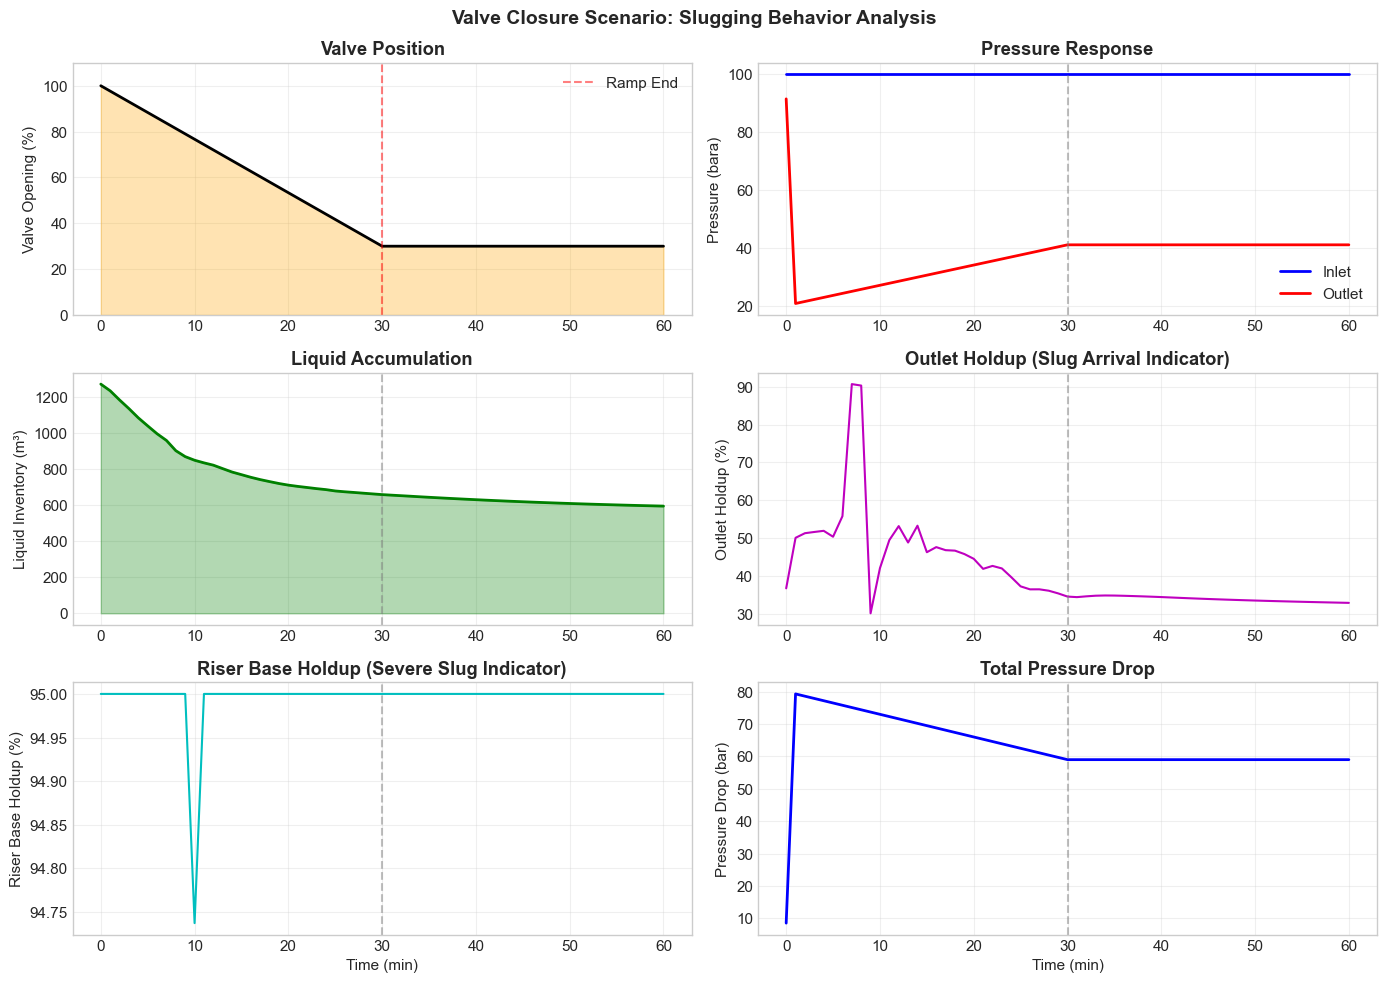

In [14]:
def run_slugging_scenario():
    """
    Run a scenario that demonstrates slugging behavior.
    """
    print("🌊 Running Slugging Analysis Scenario")
    print("="*50)
    print("Scenario: Valve closure from 100% to 30% over 30 minutes")
    print("="*50)
    
    # Create fresh system
    pipe, inlet = create_pipeline_system(MASS_FLOW_RATE)
    pipe.run()
    
    run_id = JavaUUID.randomUUID()
    
    # Simulation parameters
    dt = 60.0  # 1 minute steps
    total_time = 3600.0  # 1 hour
    ramp_time = 1800.0  # 30 minutes to close valve
    
    # Storage
    times = []
    inlet_pressures = []
    outlet_pressures = []
    liquid_inventories = []
    outlet_holdups = []
    valve_positions = []
    riser_base_holdups = []
    
    # Initial state
    p_profile = np.array(pipe.getPressureProfile()) / 1e5
    liq_holdup = np.array(pipe.getLiquidHoldupProfile())
    
    times.append(0)
    inlet_pressures.append(p_profile[0])
    outlet_pressures.append(p_profile[-1])
    liquid_inventories.append(pipe.getLiquidInventory("m3"))
    outlet_holdups.append(liq_holdup[-1])
    valve_positions.append(1.0)
    riser_base_holdups.append(liq_holdup[N_PIPELINE_SECTIONS])
    
    print(f"\nInitial state: Inlet P = {p_profile[0]:.1f} bara, Liquid = {liquid_inventories[-1]:.1f} m³")
    print("\nRunning transient simulation...")
    
    t = dt
    while t <= total_time:
        # Calculate valve position (ramp down then hold)
        if t <= ramp_time:
            valve_opening = 1.0 - 0.7 * (t / ramp_time)  # 100% -> 30%
        else:
            valve_opening = 0.3  # Hold at 30%
        
        # Adjust outlet pressure based on valve
        effective_outlet_P = OUTLET_PRESSURE + (1.0 - valve_opening) * 30.0
        pipe.setOutletPressure(float(effective_outlet_P), "bara")
        
        # Run transient step
        pipe.runTransient(float(dt), run_id)
        
        # Record state
        p_profile = np.array(pipe.getPressureProfile()) / 1e5
        liq_holdup = np.array(pipe.getLiquidHoldupProfile())
        
        times.append(t)
        inlet_pressures.append(p_profile[0])
        outlet_pressures.append(p_profile[-1])
        liquid_inventories.append(pipe.getLiquidInventory("m3"))
        outlet_holdups.append(liq_holdup[-1])
        valve_positions.append(valve_opening)
        riser_base_holdups.append(liq_holdup[N_PIPELINE_SECTIONS])
        
        t += dt
    
    print(f"Final state: Inlet P = {inlet_pressures[-1]:.1f} bara, Liquid = {liquid_inventories[-1]:.1f} m³")
    
    # Plot results
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    t_min = np.array(times) / 60
    
    # Valve position
    axes[0, 0].plot(t_min, np.array(valve_positions)*100, 'k-', linewidth=2)
    axes[0, 0].fill_between(t_min, np.array(valve_positions)*100, alpha=0.3, color='orange')
    axes[0, 0].axvline(x=ramp_time/60, color='red', linestyle='--', alpha=0.5, label='Ramp End')
    axes[0, 0].set_ylabel('Valve Opening (%)')
    axes[0, 0].set_title('Valve Position', fontweight='bold')
    axes[0, 0].set_ylim(0, 110)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Pressures
    axes[0, 1].plot(t_min, inlet_pressures, 'b-', linewidth=2, label='Inlet')
    axes[0, 1].plot(t_min, outlet_pressures, 'r-', linewidth=2, label='Outlet')
    axes[0, 1].axvline(x=ramp_time/60, color='gray', linestyle='--', alpha=0.5)
    axes[0, 1].set_ylabel('Pressure (bara)')
    axes[0, 1].set_title('Pressure Response', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Liquid inventory
    axes[1, 0].plot(t_min, liquid_inventories, 'g-', linewidth=2)
    axes[1, 0].fill_between(t_min, liquid_inventories, alpha=0.3, color='green')
    axes[1, 0].axvline(x=ramp_time/60, color='gray', linestyle='--', alpha=0.5)
    axes[1, 0].set_ylabel('Liquid Inventory (m³)')
    axes[1, 0].set_title('Liquid Accumulation', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Outlet holdup (slug indicator)
    axes[1, 1].plot(t_min, np.array(outlet_holdups)*100, 'm-', linewidth=1.5)
    axes[1, 1].axvline(x=ramp_time/60, color='gray', linestyle='--', alpha=0.5)
    axes[1, 1].set_ylabel('Outlet Holdup (%)')
    axes[1, 1].set_title('Outlet Holdup (Slug Arrival Indicator)', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Riser base holdup
    axes[2, 0].plot(t_min, np.array(riser_base_holdups)*100, 'c-', linewidth=1.5)
    axes[2, 0].axvline(x=ramp_time/60, color='gray', linestyle='--', alpha=0.5)
    axes[2, 0].set_xlabel('Time (min)')
    axes[2, 0].set_ylabel('Riser Base Holdup (%)')
    axes[2, 0].set_title('Riser Base Holdup (Severe Slug Indicator)', fontweight='bold')
    axes[2, 0].grid(True, alpha=0.3)
    
    # Pressure drop
    pressure_drop = np.array(inlet_pressures) - np.array(outlet_pressures)
    axes[2, 1].plot(t_min, pressure_drop, 'b-', linewidth=2)
    axes[2, 1].axvline(x=ramp_time/60, color='gray', linestyle='--', alpha=0.5)
    axes[2, 1].set_xlabel('Time (min)')
    axes[2, 1].set_ylabel('Pressure Drop (bar)')
    axes[2, 1].set_title('Total Pressure Drop', fontweight='bold')
    axes[2, 1].grid(True, alpha=0.3)
    
    fig.suptitle('Valve Closure Scenario: Slugging Behavior Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return pipe, times, liquid_inventories, outlet_holdups

# Run the slugging scenario
pipe_result, times_result, liq_result, holdup_result = run_slugging_scenario()

## 📖 Summary and Key Observations

### What We Learned

1. **Terrain Effects**: Valleys in the pipeline profile cause liquid accumulation due to gravitational separation

2. **Riser Base Behavior**: The S-riser base is a critical location for severe slugging initiation

3. **Valve Closure Effects**: Reducing valve opening:
   - Increases back pressure
   - Reduces gas velocity
   - Promotes liquid accumulation
   - Can trigger or suppress slugging depending on conditions

4. **Flow Regime Transitions**: The two-fluid model captures transitions between:
   - Stratified flow (low gas velocity)
   - Slug flow (intermediate conditions)
   - Annular flow (high gas velocity)

### OLGA Two-Fluid Model Advantages

- **Separate Phase Velocities**: Captures slip between gas and liquid
- **Terrain Tracking**: Predicts liquid accumulation in valleys
- **Severe Slug Model**: Detects riser-base slugging conditions
- **Lagrangian Slug Tracking**: Follows individual slugs through the system

### Applications

- Pipeline design optimization
- Slugcatcher sizing
- Turndown analysis
- Riser design
- Flow assurance studies

In [15]:
print("✅ Notebook complete!")
print("")
print("🔗 Related Resources:")
print("   - NeqSim TwoFluidPipe documentation")
print("   - OLGA two-fluid model comparison guide")
print("   - Pipeline liquid accumulation examples")

✅ Notebook complete!

🔗 Related Resources:
   - NeqSim TwoFluidPipe documentation
   - OLGA two-fluid model comparison guide
   - Pipeline liquid accumulation examples
